# DTSA-5511 Final Project
Author: Alan Klein

Create Date: 2025-07-21

github link: https://github.com/Saganoky/DTSA-5511-Deep-Learning-Final-Project

## Project Topic
Twitter now called X is a treasure trove a valuable information.  Being able to use Tweets to predict an attribute of the person writing the Tweet can be incredibly useful.  For example, this information can be used for targeted marketing.  This project will tackle a Kaggle competition where the goal is to use Tweets to predict someones political affiliation.  For more information on the contest click the link [here](https://www.kaggle.com/competitions/congressionaltweetcompetitionspring2022/). [1]  My approach will be to use an LSTM, GRU, and a Bi-Directional LSTM and evaluate their performance.


## Setup
The code below imports all the required packages.  This repo uses UV for package management, see https://docs.astral.sh/uv/ for more information.  If you are not familiar with UV I highly recommend you check it out. It fast and easy to use. Additionally, it is being used more and more in industry.

In [71]:
import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

# We'll be using Pytorch's text library called torchtext! 
from tqdm.notebook import trange, tqdm

import numpy as np
import matplotlib.pyplot as plt 

import re

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from collections import Counter
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from keras import layers
from keras import ops
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


[nltk_data] Downloading package punkt to /home/aklein01/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/aklein01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/aklein01/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data

One of the best places to find information about a dataset is by reading about the data from the source.  Per the Kaggle competition[1] page.

- The dataset is a collection of tweets posted by Congressional politicians on Twitter [excluding tweets with no hashtags.]

- Files
    - congressional_tweet_training_data.csv - the training set consisting of 592,803 records
    - congressional_tweet_test_data.csv - the test set consisting of 265,000 records
    - sample_submission.csv - a sample submission file in the correct format

- Column Descriptions
    - Id : id number associated with the tweet
    - favorite _ count : number of times the tweet was favorited
    - full_text : full text of the tweet
    - hashtags : list of hashtags included in the tweet
    - retweet_count : number of times the tweet has been retweeted
    - year : year of the tweet
    - party : partisanship of the owner of the tweet [D = 'Democrat', R = 'Republican'].  This column is called party_id in the training data and party in the test data.  It is always set to D in the test data.


In [6]:
# This sets up the Kaggle API.  You need to have a Kaggle account and a token to be able to run this code.  
# This video gives a pretty good explanation of how to get the token: https://www.youtube.com/watch?v=gkEbaMgvLs8&t=188s
api = KaggleApi()
api.authenticate()

In [7]:
# Run these two commands to download and unzip the data sets into the data folder.
# !kaggle competitions download -c congressionaltweetcompetitionspring2022
# !unzip congressionaltweetcompetitionspring2022.zip -d data/

In [8]:
test = pd.read_csv('data/congressional_tweet_test_data.csv')
train = pd.read_csv('data/congressional_tweet_training_data.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [9]:
# Basic information about the datasets
print("Test Data:")
print("Shape:", test.shape)
print("Head:")
print(test.head())
print("Info:")
print(test.info())
print("Describe:")
print(test.describe())

print("\nTrain Data:")
print("Shape:", train.shape)
print("Head:")
print(train.head())
print("Info:")
print(train.info())
print("Describe:")
print(train.describe())

print("\nSample Submission Data:")
print("Shape:", sample_submission.shape)
print("Head:")
print(sample_submission.head())

Test Data:
Shape: (265000, 7)
Head:
   Id  favorite_count                                          full_text  \
0   0              70  b'#TaxReform improved the playing field for Am...   
1   1              27  b'This #NativeWomensEqualPay Day, we recommit ...   
2   2              49  b"\xe2\x80\x9cI became convinced that our gene...   
3   3              14  b'During #NationalAdoptionMonth, we honor the ...   
4   4              13  b'Happy #AirborneDay to our @USArmy paratroope...   

                        hashtags  retweet_count    year party  
0                      TaxReform             13  2018.0     D  
1           NativeWomensEqualPay             11     NaN     D  
2     MeToo ShatteringTheSilence             24  2017.0     D  
3          NationalAdoptionMonth              2  2019.0     D  
4  AirborneDay AirborneAllTheWay              7  2018.0     D  
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265000 entries, 0 to 264999
Data columns (total 7 columns):
 #   Co

## Exploratory Data Analysis
- The training and test datasets exhibit similar distributions across most features. The primary exception is the retweet count, which shows a notable difference due to the presence of an extreme outlier in the test set.

- The class distribution in the training set is relatively balanced, so no rebalancing techniques will be applied.

- There are missing values in the year column, with approximately 20,000 missing entries in the training data and around 10,000 in the test data.

- The hashtags column often contains multiple hashtags per entry. The top 20 hashtags are consistent between the training and test sets.

- The word count distributions in the full_text column are also similar between the two datasets.

- The full_text field requires cleaning, as it contains artifacts such as leading byte strings (e.g., b'...'), hashtags, and user mentions (e.g., @username).

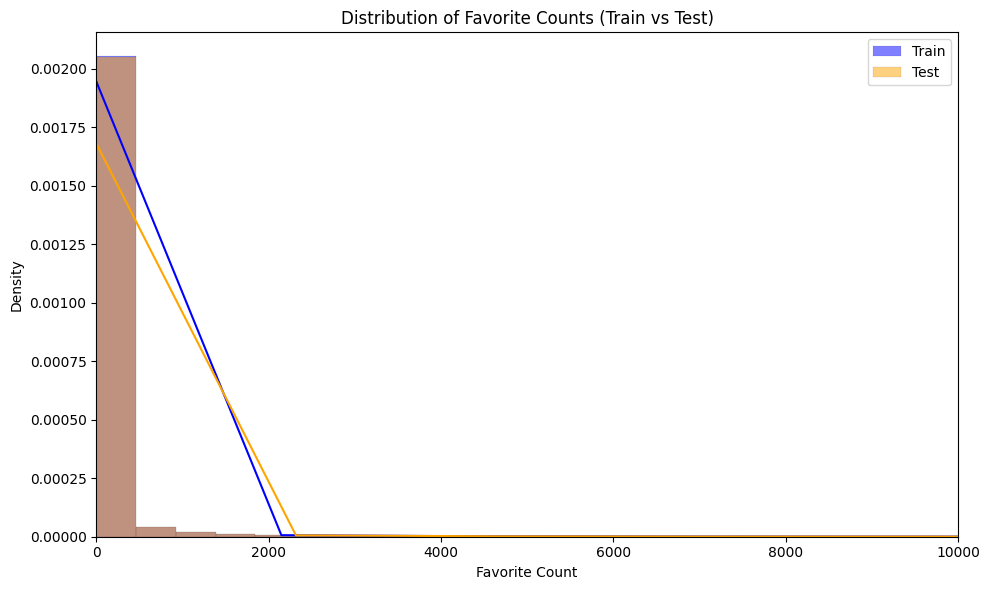

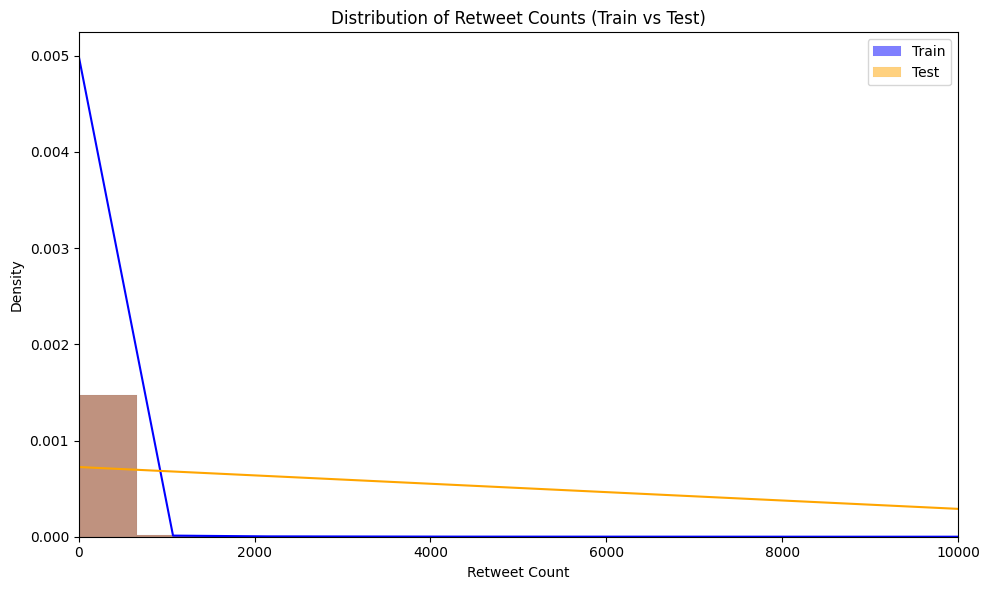

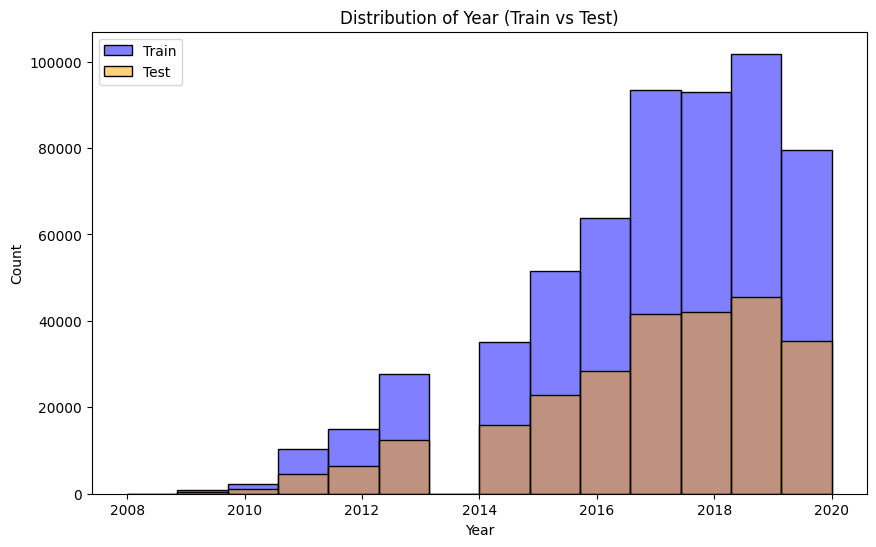

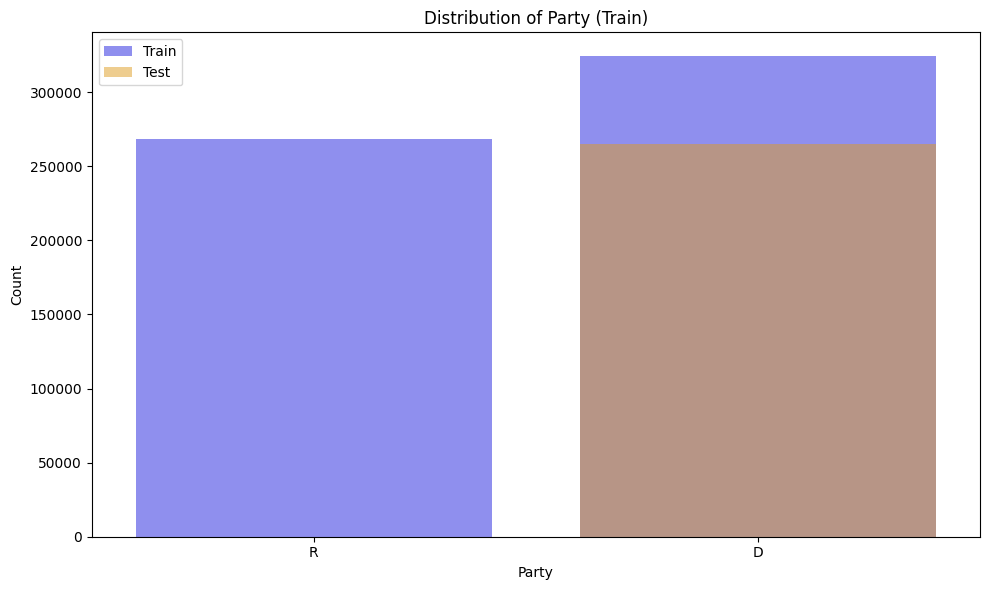

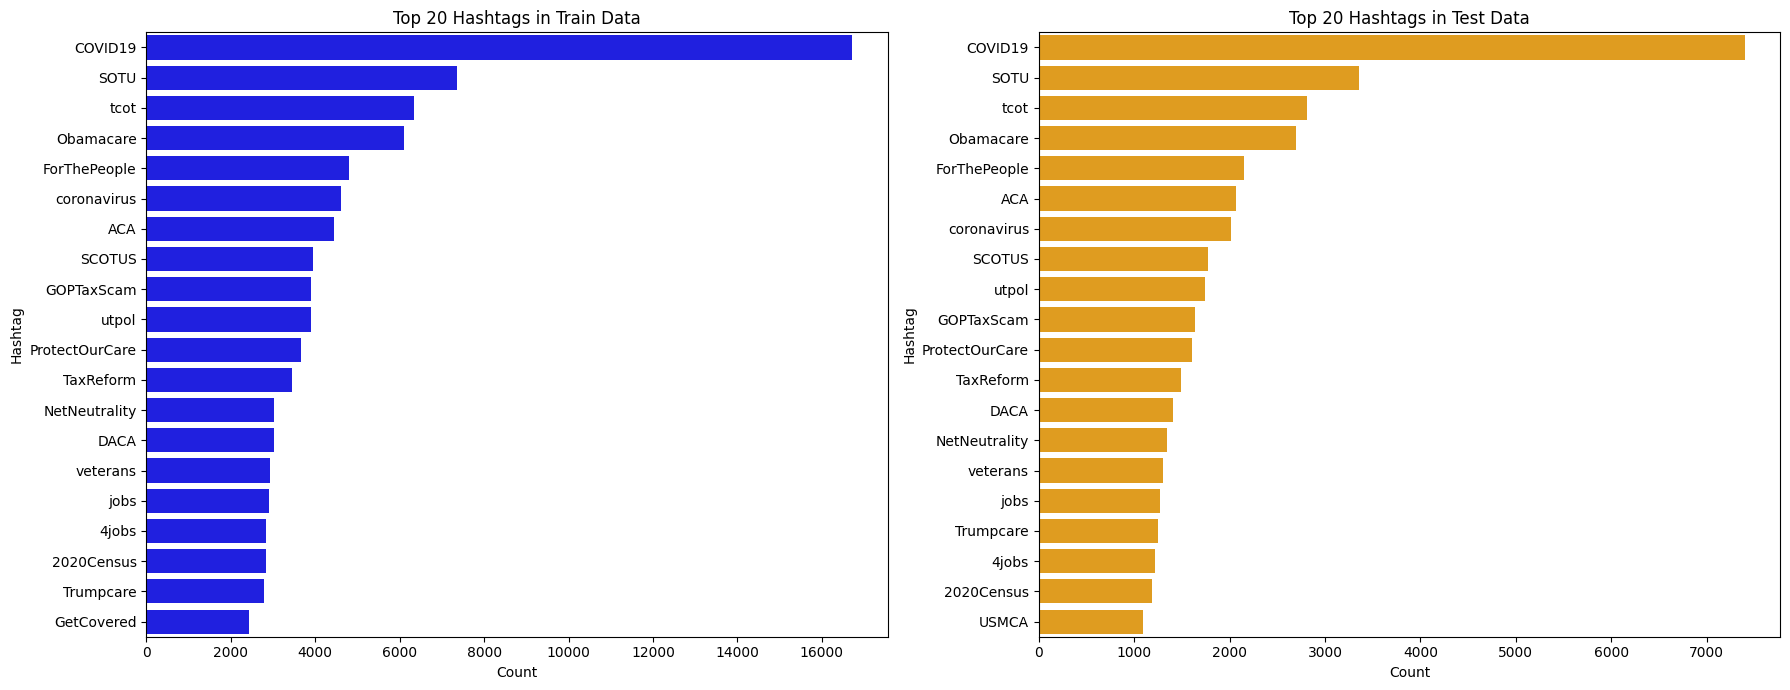

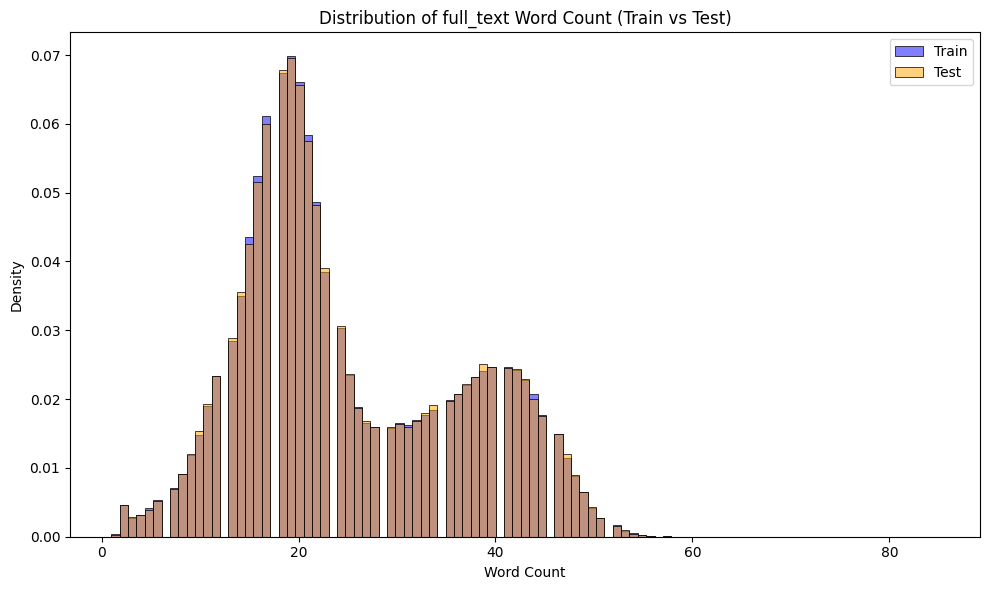

In [10]:

# Plot histograms for train and test favorite counts
# Use the same bins for both train and test favorite_count
all_favorite_counts = pd.concat([train['favorite_count'], test['favorite_count']])
bins = np.linspace(all_favorite_counts.min(), all_favorite_counts.max(), 1000)

plt.figure(figsize=(10, 6))
sns.histplot(train['favorite_count'], bins=bins, kde=True, color='blue', label='Train', stat='density', alpha=0.5)
sns.histplot(test['favorite_count'], bins=bins, kde=True, color='orange', label='Test', stat='density', alpha=0.5)
plt.xlim(0, 10000)
plt.title('Distribution of Favorite Counts (Train vs Test)')
plt.xlabel('Favorite Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for train and test retweet counts
# Use the same bins for both train and test retweet_count
all_retweet_counts = pd.concat([train['retweet_count'], test['retweet_count']])
bins = np.linspace(all_retweet_counts.min(), all_retweet_counts.max(), 5000)

plt.figure(figsize=(10, 6))
sns.histplot(train['retweet_count'], bins=bins, kde=True, color='blue', label='Train', stat='density', alpha=0.5)
sns.histplot(test['retweet_count'], bins=bins, kde=True, color='orange', label='Test', stat='density', alpha=0.5)
plt.xlim(0, 10000)
plt.title('Distribution of Retweet Counts (Train vs Test)')
plt.xlabel('Retweet Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Plot histograms for train and test year
plt.figure(figsize=(10, 6))
sns.histplot(train['year'], bins=14, color='blue', label='Train', alpha=0.5)
sns.histplot(test['year'], bins=14, color='orange', label='Test', alpha=0.5)
plt.title('Distribution of Year (Train vs Test)')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

# Plot histograms for train and test party
plt.figure(figsize=(10, 6))
sns.countplot(x='party_id', data=train, color='blue', label='Train', alpha=0.5)
sns.countplot(x='party', data=test, color='orange', label='Test', alpha=0.5)
plt.title('Distribution of Party (Train)')
plt.xlabel('Party')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Helper function to split and clean hashtags
def extract_hashtags(series):
    hashtags = []
    for entry in series:
        if isinstance(entry, str):
            hashtags.extend([tag.strip() for tag in entry.split() if tag.strip()])
    return hashtags

# Get top 20 hashtags for train and test
train_hashtags = extract_hashtags(train['hashtags'])
test_hashtags = extract_hashtags(test['hashtags'])

train_top20 = Counter(train_hashtags).most_common(20)
test_top20 = Counter(test_hashtags).most_common(20)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
sns.barplot(x=[x[1] for x in train_top20], y=[x[0] for x in train_top20], ax=axes[0], color='blue')
axes[0].set_title('Top 20 Hashtags in Train Data')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Hashtag')

sns.barplot(x=[x[1] for x in test_top20], y=[x[0] for x in test_top20], ax=axes[1], color='orange')
axes[1].set_title('Top 20 Hashtags in Test Data')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Hashtag')

plt.tight_layout()
plt.show()


# Calculate word counts for full_text in train and test sets
# Calculate word counts for full_text in train and test sets
train_lengths = train['full_text'].apply(lambda x: len(str(x).split()))
test_lengths = test['full_text'].apply(lambda x: len(str(x).split()))

# Use the same bins for both train and test word counts
all_lengths = pd.concat([train_lengths, test_lengths])
bins = np.linspace(all_lengths.min(), all_lengths.max(), 100)

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, bins=bins, color='blue', label='Train', stat='density', alpha=0.5)
sns.histplot(test_lengths, bins=bins, color='orange', label='Test', stat='density', alpha=0.5)
plt.title('Distribution of full_text Word Count (Train vs Test)')
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## Data Cleaning
My plan for data cleaning and prep is as follows. First I'll process the full text by removing URLs, mentions, hashtags, special characters, extra spaces, and make everything lowercase.  Next, the year missing year values will be replaced with noyear.  The text will also be fed through an stemmer, lemmatizer, and stop words will be removed. After that year, full_text, and the hashtags will be concatenated together.  This will create a single text string to be vectorized and fed into the models.  The training data will be split into a train and validation set using a 80-20 split.

In [11]:
# Function to preprocess text data
def preprocess_text(text):
    # remove unicode special characters
    text = re.sub(r"\\x..", ' ', text, re.A)
    # remove b at start of string
    text = re.sub(r"^b", '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    # Remove special characters (keep only letters, numbers, and spaces)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    # stemming using NLTK's PorterStemmer
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())
    # lemmatization using NLTK's WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    # Stop word removal using NLTK
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)        
    # Remove leading and trailing spaces
    text = text.strip()
    return text

def preprocess_dataset(df):
    # Apply preprocessing to the 'full_text' column
    df['full_text'] = df['full_text'].apply(preprocess_text)
    # apply preprocessing to the 'hashtags' column
    df['hashtags'] = df['hashtags'].apply(preprocess_text)
    # convert year to string with no decimal places
    df['year'] = df['year'].astype(str).str.replace('.0', '', regex=False)
    # Replace NaN values in year with 'noyear'
    df['year'] = df['year'].replace('nan','noyear')
    # Create a concatenation of columns for the output
    X = df['year'].astype(str) + ' ' + \
        df['full_text'].astype(str) + ' ' + \
        df['hashtags'].astype(str)
    # Remove leading and trailing spaces
    X = X.str.strip()
    return X

In [12]:
# Preprocess and split the dataset
train_preprocessed = preprocess_dataset(train)

# Map 'D' to 1 and 'R' to 0 in the target variable
train_y_preprocessed = train['party_id'].map({'D': 1, 'R': 0})

X_train, X_val, y_train, y_val = train_test_split(train_preprocessed, train_y_preprocessed, test_size=0.2, random_state=1337)


## Model

This notebook will classify the tweets using two models.

#### Bi-Directional LSTM
This model was selected because it should allow information to flow across the entire tweet.  I'm hoping this will lead to better text classification compared to a standard LSTM.  This model will use binary cross entropy for the loss function as its a binary classification problem, also it will use Adam for optimization.

This model consists of 5 layer
1. An encoder, which vectorizes the data with 8000 tokens, and a max tweet size of 60.
2. An embedding layer with 64 outputs
3. Bi directional LSTM with 64 nodes
4. A dense NN with 64 node and relu activation
5. A dense NN with 1 node 

#### Transformer
This model was selected because in theory it should allow a tweet to context for the entire Tweet.  This model was created using the Keras tutortial here [3].  Similar to above I use binary cross entropy for loss and Adam for optimization.

The model consist of the following layers:
1. Encoding layer - Vectorizes the data with 8000 tokens, and a max tweet size of 60.
2. Embedding Layer - With 32 embeddings per token.
3. Transformer Block - MultiHeadAttention Layer + Dense Layer + 2x normalization + 2x Dropout
4. Average Pooling Layer
5. Dropout - 10%
6. Dense NN Layer - ReLu activation
7. Dropout - 10%
8. Dense NN Layer - Sigmoid Activation




In [13]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [14]:
# Convert training and validation data to TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val.values))

# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


I0000 00:00:1753288612.558443     867 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:0a:00.0, compute capability: 8.9


In [15]:
# use the keras text encoder limit to 8000 words based on a recommendation from [2].
VOCAB_SIZE = 8000
encoder = tf.keras.layers.TextVectorization(standardize=None,
    max_tokens = VOCAB_SIZE,
    output_sequence_length=60,  # Set a maximum sequence length based on histogram of word counts, most tweets are less than 60 words
    )
encoder.adapt(train_dataset.map(lambda text, label: text))

2025-07-23 11:37:29.611832: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [16]:
# Define the model architecture
# We will use a simple LSTM model followed by a dense layer for binary classification.
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True
        ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [17]:
# Define the loss, optimizer, and metrics for the model
# as we are doing binary classification, we will use BinaryCrossentropy as the loss function
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])


In [18]:
# Train the model
history = model.fit(train_dataset, epochs=2,
                    validation_data=val_dataset)

Epoch 1/2


I0000 00:00:1753288651.870776    6219 cuda_dnn.cc:529] Loaded cuDNN version 90300


7411/7411 ━━━━━━━━━━━━━━━━━━━━ 148s 20ms/step - accuracy: 0.7499 - loss: 0.4428 - val_accuracy: 0.8146 - val_loss: 0.3379
Epoch 2/2
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 149s 20ms/step - accuracy: 0.8291 - loss: 0.3302 - val_accuracy: 0.8191 - val_loss: 0.3314


In [19]:
val_loss, val_acc = model.evaluate(val_dataset)

print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

1853/1853 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.8207 - loss: 0.3287
Validation Loss: 0.3313615620136261
Validation Accuracy: 0.8190720677375793


(0.0, 0.3777733713388443)

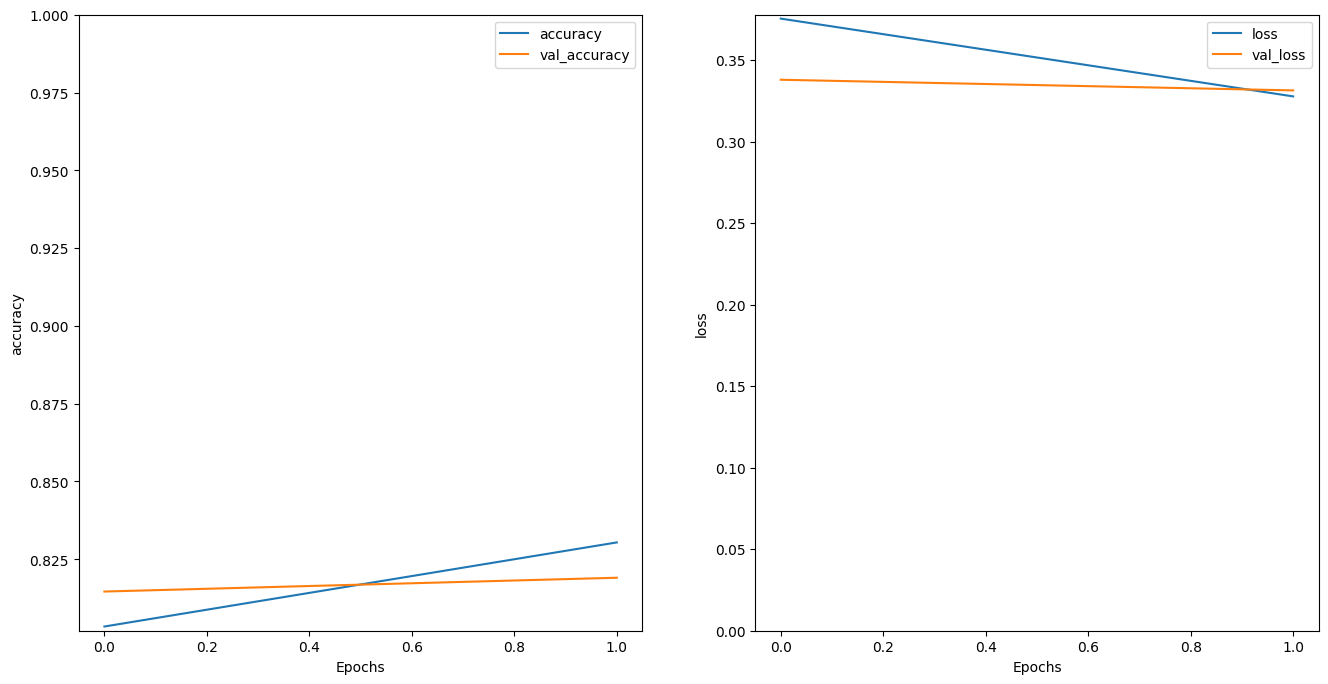

In [20]:
# Plot the training and validation accuracy and loss
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

3706/3706 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step


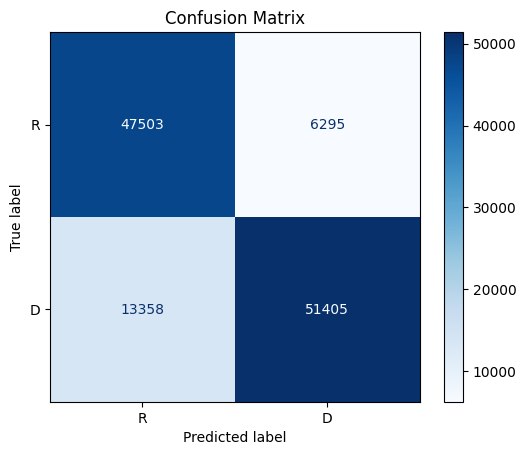

In [ ]:
# Get predictions on the validation set
y_val_pred_logits = model.predict(np.array(X_val.values, dtype=object))
y_val_pred = (tf.sigmoid(y_val_pred_logits).numpy().flatten() > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'D'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Predict on the test dataset
test_texts = train_preprocessed = preprocess_dataset(test)

test_predictions = model.predict(np.array(test_texts, dtype=object))
# Convert logits to binary predictions
test_preds = (test_predictions > 0).astype(int).flatten()
# Map 1 to 'D' and 0 to 'R'
test_preds = np.where(test_preds == 1, 'D', 'R')

sample_submission['party'] = test_preds
sample_submission.to_csv('data/LSTM_submission_1.csv', index=False)

8282/8282 ━━━━━━━━━━━━━━━━━━━━ 55s 7ms/step


In [76]:
# Submission to Kaggle
!kaggle competitions submit -c congressionaltweetcompetitionspring2022 -f data/LSTM_submission_1.csv -m "simple LSTM model"

100%|██████████████████████████████████████| 2.17M/2.17M [00:00<00:00, 4.63MB/s]
Successfully submitted to Congressional Tweet Competition - Spring 2022

In [26]:
# Transformer Model Based on the Keras Tutorial [3]

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)
    

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions  
    


In [77]:
vocab_size = 8000  # Only consider the top 8k words
maxlen = 60 # Only consider the first 60 words for each tweet, this is based on the histogram of word counts, most tweets are less than 60 words
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

def create_transformer_model(vocab_size, maxlen, embed_dim, num_heads, ff_dim):
    inputs = layers.Input(shape=(maxlen,))
    # Add the encoding layer to convert text to integer sequences
    transformer_encoder = tf.keras.layers.TextVectorization(standardize=None,
        max_tokens=vocab_size,
        output_sequence_length=maxlen)
    inputs = transformer_encoder(inputs)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Dense(20, activation="relu")(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs=inputs, outputs=outputs)

transformer_model = create_transformer_model(
    vocab_size=vocab_size,
    maxlen=maxlen,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim
)

In [67]:
transformer_encoder.adapt(np.array(X_train))

# Encode the text data to integer sequences using the already adapted transformer_encoder
X_train_seq = transformer_encoder(np.array(X_train)).numpy()
X_val_seq = transformer_encoder(np.array(X_val)).numpy()

transformer_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
transformer_history = transformer_model.fit(
    X_train_seq, y_train.values, batch_size=BATCH_SIZE, epochs=2, validation_data=(X_val_seq, y_val.values)
)

Epoch 1/2
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 46s 6ms/step - accuracy: 0.7823 - loss: 0.4199 - val_accuracy: 0.8377 - val_loss: 0.3336
Epoch 2/2
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8411 - loss: 0.3242 - val_accuracy: 0.8401 - val_loss: 0.3256


3706/3706 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8417 - loss: 0.3227
Validation Loss: 0.3255822956562042
Validation Accuracy: 0.8401244878768921


(0.0, 0.3668724179267883)

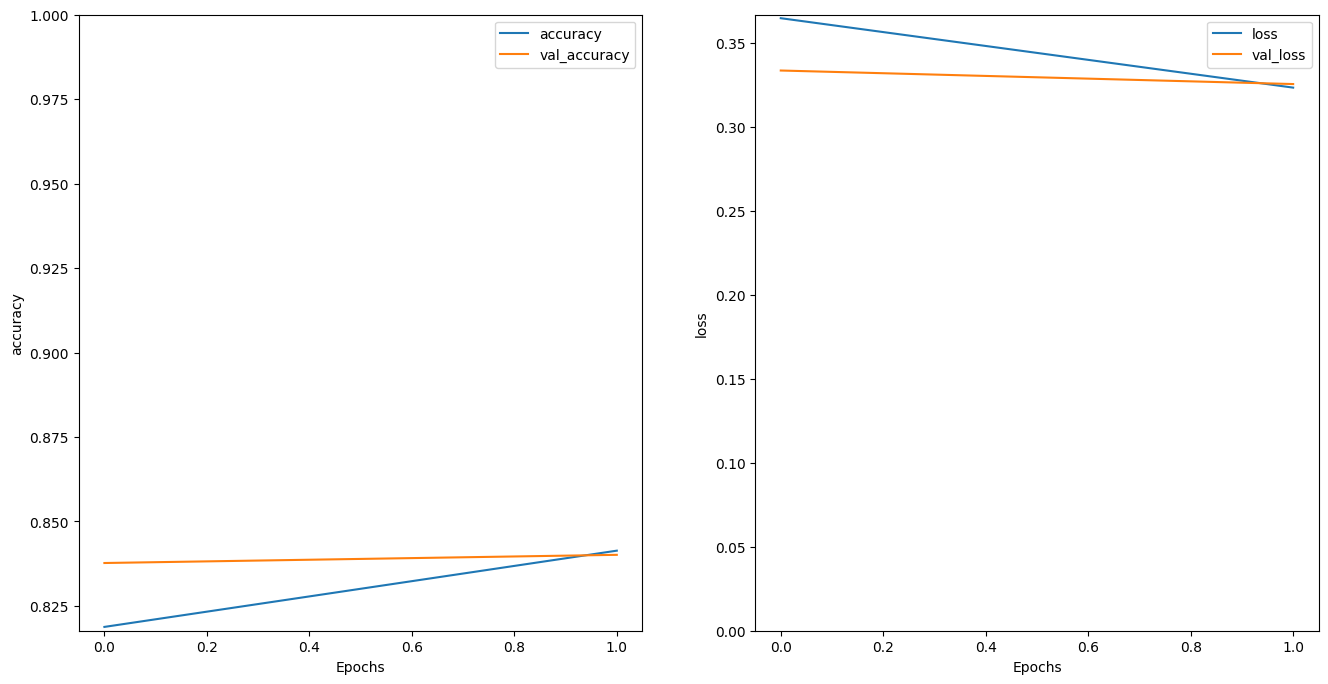

In [68]:
val_loss, val_acc = transformer_model.evaluate(x=X_val_seq, y=y_val.values)

print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)

# Plot the training and validation accuracy and loss
def plot_graphs(transformer_history, metric):
  plt.plot(transformer_history.history[metric])
  plt.plot(transformer_history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(transformer_history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(transformer_history, 'loss')
plt.ylim(0, None)

3706/3706 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


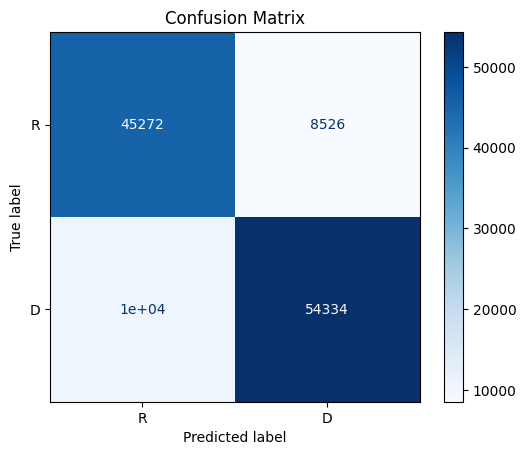

In [72]:
# Get predictions on the validation set
y_val_pred_logits = transformer_model.predict(X_val_seq)
y_val_pred = ((y_val_pred_logits > 0.5).astype(int))

# Compute confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['R', 'D'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [74]:
# Predict on the test dataset
test_texts = preprocess_dataset(test)

# Convert test texts to integer sequences using the transformer_encoder
test_texts_seq = transformer_encoder(np.array(test_texts)).numpy()

test_predictions = transformer_model.predict(test_texts_seq, batch_size=BATCH_SIZE)
# Convert logits to binary predictions
test_preds = (test_predictions > 0.5).astype(int).flatten()
# Map 1 to 'D' and 0 to 'R'
test_preds = np.where(test_preds == 1, 'D', 'R')

sample_submission['party'] = test_preds
sample_submission.to_csv('data/Transformer_submission_1.csv', index=False)

4122/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-07-23 12:34:46.239353: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 64 bytes spill stores, 64 bytes spill loads



4141/4141 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


In [75]:
# Submission to Kaggle
!kaggle competitions submit -c congressionaltweetcompetitionspring2022 -f data/Transformer_submission_1.csv -m "simple Transformer model"

100%|██████████████████████████████████████| 2.17M/2.17M [00:00<00:00, 4.40MB/s]
Successfully submitted to Congressional Tweet Competition - Spring 2022

## Hyper Parameter Tuning

As the Transformer seems to perform slightly better I decided to try and optimize the number of attention heads.  A higher number should allow for more nuanced interactions between words.  We will see if it leads to better accuracy.

In [81]:
# Define different hyperparameter combinations to try
hyperparams = [
    {'num_heads': 2},
    {'num_heads': 3},
    {'num_heads': 4},
]

# Store results for each configuration
tuning_results = []

# Loop through each configuration
for i, params in enumerate(hyperparams, 1):
    print(f"\nTraining model {i} with params: {params}")

    # Build model
    model = create_transformer_model(
        vocab_size=vocab_size,
        maxlen=maxlen,
        embed_dim=embed_dim,
        num_heads=params['num_heads'],
        ff_dim=ff_dim
    )
    
    # Compile model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    # Train model
    history = model.fit(
        X_train_seq, 
        y_train.values, 
        batch_size=BATCH_SIZE, 
        epochs=10, 
        validation_data=(X_val_seq, y_val.values)
    )

    # Evaluate model
    y_pred_proba = model.predict(X_val_seq)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    acc = np.mean(y_pred == y_val)

    # Save result
    tuning_results.append({
        'Model_Name': f"Model {i}",
        'Model': model,
        'Num Heads': params['num_heads'],
        'Accuracy': round(acc, 4),
    })

    print(f"Model {i} - Accuracy: {acc:.4f}")


🚀 Training model 1 with params: {'num_heads': 2}
Epoch 1/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 43s 5ms/step - accuracy: 0.7801 - loss: 0.4227 - val_accuracy: 0.8356 - val_loss: 0.3333
Epoch 2/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step - accuracy: 0.8411 - loss: 0.3243 - val_accuracy: 0.8410 - val_loss: 0.3224
Epoch 3/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - accuracy: 0.8498 - loss: 0.3089 - val_accuracy: 0.8468 - val_loss: 0.3160
Epoch 4/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8581 - loss: 0.2944 - val_accuracy: 0.8472 - val_loss: 0.3162
Epoch 5/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8628 - loss: 0.2839 - val_accuracy: 0.8488 - val_loss: 0.3131
Epoch 6/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8677 - loss: 0.2753 - val_accuracy: 0.8475 - val_loss: 0.3214
Epoch 7/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8720 - loss: 0.2683 - val_accuracy: 0.8480 - val_loss: 0.3213
Epoch 8/10
7411/7411 ━━━━━━━━━━━━

2025-07-23 12:58:31.382318: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 48 bytes spill stores, 48 bytes spill loads



7409/7411 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7756 - loss: 0.4269

2025-07-23 12:59:11.186581: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_17', 48 bytes spill stores, 48 bytes spill loads



7411/7411 ━━━━━━━━━━━━━━━━━━━━ 54s 6ms/step - accuracy: 0.7756 - loss: 0.4269 - val_accuracy: 0.8365 - val_loss: 0.3305
Epoch 2/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8424 - loss: 0.3230 - val_accuracy: 0.8405 - val_loss: 0.3260
Epoch 3/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8479 - loss: 0.3111 - val_accuracy: 0.8435 - val_loss: 0.3193
Epoch 4/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8558 - loss: 0.2978 - val_accuracy: 0.8469 - val_loss: 0.3176
Epoch 5/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8615 - loss: 0.2875 - val_accuracy: 0.8446 - val_loss: 0.3190
Epoch 6/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8676 - loss: 0.2772 - val_accuracy: 0.8483 - val_loss: 0.3218
Epoch 7/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8716 - loss: 0.2694 - val_accuracy: 0.8488 - val_loss: 0.3154
Epoch 8/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8768 - loss: 0.2598 - val

2025-07-23 13:04:41.493593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4 bytes spill loads

2025-07-23 13:04:41.877829: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 4 bytes spill stores, 4 bytes spill loads

2025-07-23 13:04:42.064621: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 32 bytes spill stores, 32 bytes spill loads

2025-07-23 13:04:42.324054: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 48 bytes spill stores, 48 bytes spill loads



7402/7411 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7798 - loss: 0.4220

2025-07-23 13:05:13.287138: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 16 bytes spill stores, 16 bytes spill loads



7411/7411 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7799 - loss: 0.4219

2025-07-23 13:05:23.558618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 24 bytes spill stores, 24 bytes spill loads

2025-07-23 13:05:23.586459: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 64 bytes spill stores, 64 bytes spill loads

2025-07-23 13:05:23.721485: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 16 bytes spill stores, 16 bytes spill loads



7411/7411 ━━━━━━━━━━━━━━━━━━━━ 46s 5ms/step - accuracy: 0.7799 - loss: 0.4219 - val_accuracy: 0.8363 - val_loss: 0.3315
Epoch 2/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - accuracy: 0.8414 - loss: 0.3242 - val_accuracy: 0.8416 - val_loss: 0.3241
Epoch 3/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.8498 - loss: 0.3083 - val_accuracy: 0.8447 - val_loss: 0.3170
Epoch 4/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - accuracy: 0.8581 - loss: 0.2936 - val_accuracy: 0.8475 - val_loss: 0.3153
Epoch 5/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - accuracy: 0.8645 - loss: 0.2830 - val_accuracy: 0.8490 - val_loss: 0.3217
Epoch 6/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 964s 130ms/step - accuracy: 0.8683 - loss: 0.2752 - val_accuracy: 0.8485 - val_loss: 0.3137
Epoch 7/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.8734 - loss: 0.2662 - val_accuracy: 0.8483 - val_loss: 0.3214
Epoch 8/10
7411/7411 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.8787 - loss: 0.2568 - 

2025-07-23 13:25:32.234712: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 24 bytes spill stores, 24 bytes spill loads

2025-07-23 13:25:32.394055: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 64 bytes spill stores, 64 bytes spill loads



3706/3706 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step
✅ Model 3 - Accuracy: 0.8463


In [ ]:
# Picked the best model based on accuracy.  This is the model with 3 attention heads and 10 epochs.
tuned_model = tuning_results[2]['Model']

# Predict on the test dataset
test_texts = preprocess_dataset(test)

# Convert test texts to integer sequences using the transformer_encoder
test_texts_seq = transformer_encoder(np.array(test_texts)).numpy()

test_predictions = tuned_model.predict(test_texts_seq, batch_size=BATCH_SIZE)
# Convert logits to binary predictions
test_preds = (test_predictions > 0.5).astype(int).flatten()
# Map 1 to 'D' and 0 to 'R'
test_preds = np.where(test_preds == 1, 'D', 'R')

sample_submission['party'] = test_preds
sample_submission.to_csv('data/Transformer_submission_2.csv', index=False)

4117/4141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

2025-07-23 16:57:36.890340: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 24 bytes spill stores, 24 bytes spill loads

2025-07-23 16:57:36.959793: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 16 bytes spill stores, 16 bytes spill loads

2025-07-23 16:57:36.961394: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 64 bytes spill stores, 64 bytes spill loads



4141/4141 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [87]:
# Submission to Kaggle
!kaggle competitions submit -c congressionaltweetcompetitionspring2022 -f data/Transformer_submission_2.csv -m "simple Transformer with 4 attention heads"

100%|██████████████████████████████████████| 2.17M/2.17M [00:00<00:00, 4.53MB/s]
Successfully submitted to Congressional Tweet Competition - Spring 2022

## Results and Analysis
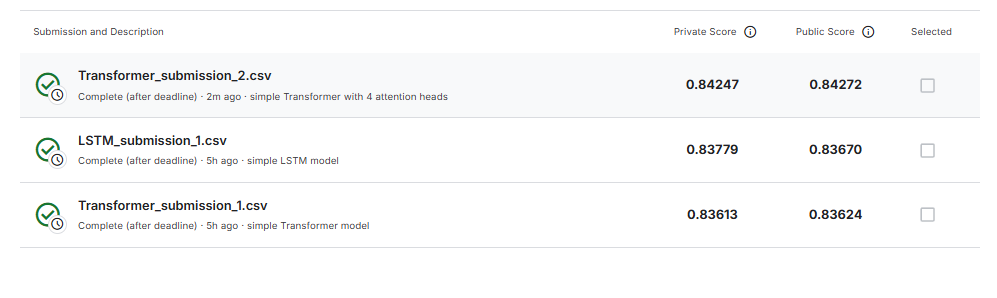


As you can see above models all performed similarly, with the transformer with 3 attention heads and 10 epochs performing best.  I would have expected the 4 attention head model to perform better.  My guess why it did not would be due to tweets not being all that long so there is not much of an advantage to having many attention heads.

## Discussion and Conclusion

The modeling was a success.  I managed to get both a bi directional LSTM and a transformer to perform with approximately 80% accuracy.  

One of the biggest challenges with deep learning is the limitations of compute power.  If models would train faster it would be much easier to try different and more deep architectures as well as tune various hyper parameters.  Some of the things to investigate next to improve model performance would be, larger number of epochs, adapative learning rate, or changing the preprocessing.

# References
[1] Cantay Caliskan. Congressional Tweet Competition - Spring 2022. https://kaggle.com/competitions/congressionaltweetcompetitionspring2022, 2022. Kaggle.

[2] https://www.rws.com/language-weaver/blog/issue-121-finding-the-optimal-vocabulary-size-for-neural-machine-translation/

[3] https://keras.io/examples/nlp/text_classification_with_transformer/